# Exploración rápida Módulo 1 (Bahrein 2024 Carrera)
Cargamos los artefactos de `data/module1_ingestion/2024_Bahrain_Grand_Prix_R/` para revisar formas de los datos y algunas visualizaciones básicas (tiempo vs velocidad, distancia vs velocidad).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

base = '../feature_extraction/data/module1_ingestion/2024_Bahrain_Grand_Prix_R'

telemetry_time = pd.read_csv(f"{base}/telemetry_time_10hz.csv")
telemetry_dist = pd.read_csv(f"{base}/telemetry_distance_aligned.csv")
meta = pd.read_csv(f"{base}/laps_metadata.csv")
laps = pd.read_csv(f"{base}/laps.csv")

pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 20)
print('Shapes -> time:', telemetry_time.shape, 'dist:', telemetry_dist.shape, 'meta:', meta.shape, 'laps:', laps.shape)
telemetry_time.head()

Shapes -> time: (19003, 15) dist: (107295, 16) meta: (20, 5) laps: (1129, 32)


,RelativeTime_s,Speed,Throttle,Brake,nGear,RPM,DRS,Distance,RelativeDistance,X,Y,Driver,LapNumber,Compound,TyreLife
0,0.0,283.075002,100.0,False,7,11262.849997,0,0.002732,5.072732e-07,-379.607928,1297.719518,1,39,SOFT,2
1,0.1,283.075002,100.0,False,7,11262.849997,0,0.002732,5.072732e-07,-379.607928,1297.719518,1,39,SOFT,2
2,0.2,285.000000,100.0,False,7,11259.000000,0,12.195000,2.264589e-03,-371.982577,1455.807887,1,39,SOFT,2
3,0.3,285.278572,100.0,False,7,11285.185757,0,18.382242,3.413548e-03,-369.000000,1516.000000,1,39,SOFT,2
4,0.4,285.278572,100.0,False,7,11285.185757,0,18.382242,3.413548e-03,-369.000000,1516.000000,1,39,SOFT,2


In [2]:
# Resumen de las vueltas usadas (vuelta más rápida por piloto)
meta[['Driver','LapNumber','LapTimeSeconds','Compound','TyreLife']].sort_values('LapTimeSeconds').reset_index(drop=True)

,Driver,LapNumber,LapTimeSeconds,Compound,TyreLife
0,1,39,92.608,SOFT,2
1,16,36,94.090,HARD,2
2,14,48,94.199,HARD,7
3,11,40,94.364,SOFT,4
4,4,35,94.476,HARD,2
5,55,44,94.507,HARD,9
6,44,39,94.722,HARD,6
7,2,42,94.735,SOFT,2
8,10,45,94.805,SOFT,2
9,27,46,94.834,SOFT,6


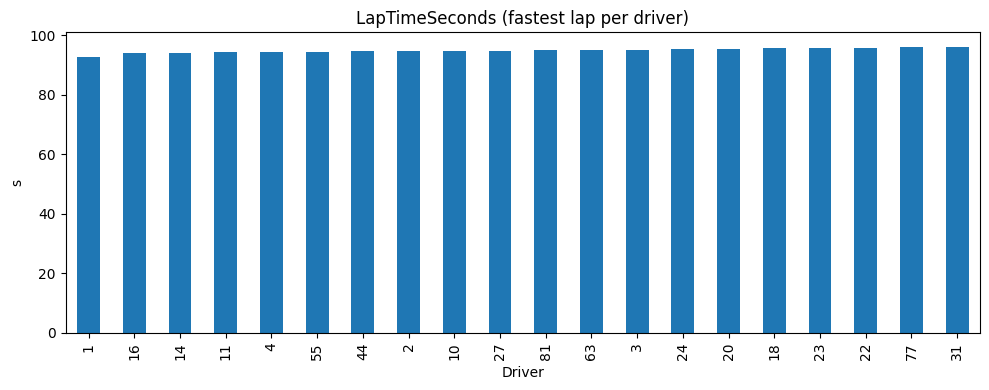

In [3]:
# Distribución de tiempos de vuelta por piloto
lap_summary = meta[['Driver','LapTimeSeconds']].sort_values('LapTimeSeconds')
ax = lap_summary.plot(kind='bar', x='Driver', y='LapTimeSeconds', figsize=(10,4), legend=False, title='LapTimeSeconds (fastest lap per driver)')
ax.set_ylabel('s')
plt.tight_layout()
plt.show()

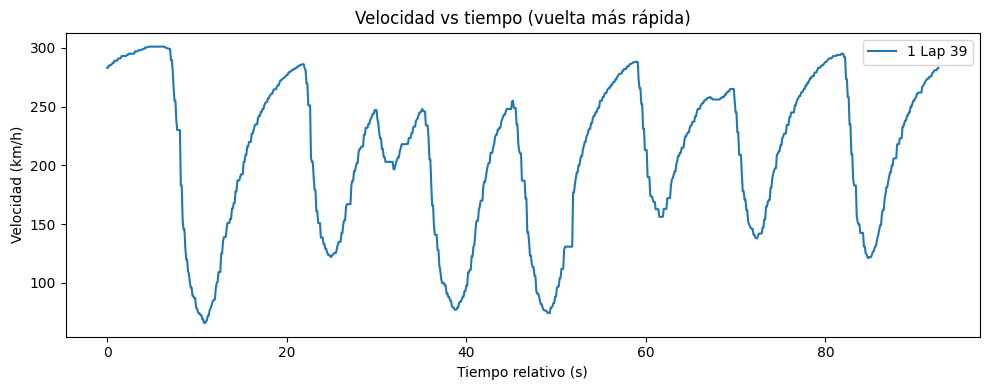

In [4]:
# Velocidad vs tiempo (10 Hz) para el piloto más rápido
fastest = meta.sort_values('LapTimeSeconds').iloc[0]
d = fastest['Driver']; lap = fastest['LapNumber']
sel = telemetry_time[(telemetry_time.Driver == d) & (telemetry_time.LapNumber == lap)]
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(sel['RelativeTime_s'], sel['Speed'], label=f"{d} Lap {lap}")
ax.set_xlabel('Tiempo relativo (s)')
ax.set_ylabel('Velocidad (km/h)')
ax.set_title('Velocidad vs tiempo (vuelta más rápida)')
ax.legend()
plt.tight_layout()
plt.show()

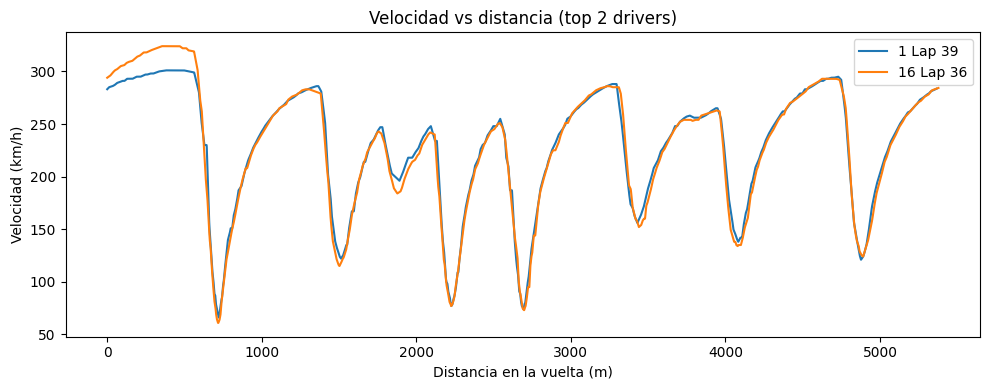

In [5]:
# Velocidad vs distancia (ghost) para los dos más rápidos
top2 = meta.sort_values('LapTimeSeconds').head(2)
fig, ax = plt.subplots(figsize=(10,4))
for _, row in top2.iterrows():
    d = row['Driver']; lap = row['LapNumber']
    sel = telemetry_dist[(telemetry_dist.Driver == d) & (telemetry_dist.LapNumber == lap)]
    ax.plot(sel['Distance_m'], sel['Speed'], label=f"{d} Lap {lap}")
ax.set_xlabel('Distancia en la vuelta (m)')
ax.set_ylabel('Velocidad (km/h)')
ax.set_title('Velocidad vs distancia (top 2 drivers)')
ax.legend()
plt.tight_layout()
plt.show()

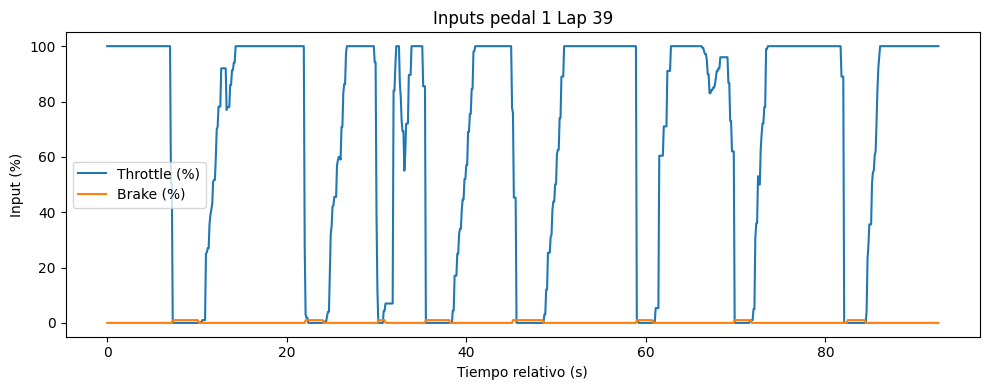

In [6]:
# Relación Throttle/Brake vs tiempo para el piloto más rápido
sel_pedal = telemetry_time[(telemetry_time.Driver == fastest['Driver']) & (telemetry_time.LapNumber == fastest['LapNumber'])]
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(sel_pedal['RelativeTime_s'], sel_pedal['Throttle'], label='Throttle (%)')
ax.plot(sel_pedal['RelativeTime_s'], sel_pedal['Brake'], label='Brake (%)')
ax.set_xlabel('Tiempo relativo (s)')
ax.set_ylabel('Input (%)')
ax.set_title(f'Inputs pedal {fastest["Driver"]} Lap {fastest["LapNumber"]}')
ax.legend()
plt.tight_layout()
plt.show()

## Exploración Módulo 2 (dinámicas, jerks, energía)

In [7]:
# Cargar telemetría enriquecida y features por vuelta
enriched = pd.read_csv(f"{base}/telemetry_time_10hz_enriched.csv")
lap_feat = pd.read_csv(f"{base}/lap_features_module2.csv")
print('Shapes -> enriched:', enriched.shape, 'lap_features:', lap_feat.shape)
lap_feat.head()

Shapes -> enriched: (19003, 23) lap_features: (20, 13)


,Driver,LapNumber,LapTimeSeconds,Compound,TyreLife,Avg_Speed_mps,Avg_Throttle,Brake_Aggression,MeanAbs_Jerk_Long,MeanAbs_Jerk_Lat,Max_Lateral_g,Max_Longitudinal_g,Energy_Index
0,1,39,92.608,SOFT,2,57.866350,69.065407,0.391546,3607.637894,399.999948,86.317673,422.439761,3.464516e+07
1,2,42,94.735,SOFT,2,56.576900,65.454008,0.390730,3457.147465,359.422811,109.654590,291.621875,3.262333e+07
2,3,37,95.163,SOFT,2,56.385182,65.405160,0.395076,3494.733407,343.362993,72.325362,664.660862,3.453410e+07
3,4,35,94.476,HARD,2,56.821504,64.499734,0.404128,3508.076008,359.348400,68.614629,608.658692,3.400033e+07
4,10,45,94.805,SOFT,2,56.675055,66.537160,0.408801,3566.507057,366.063718,132.329434,709.336523,3.666045e+07


In [8]:
# Top 5 vueltas por LapTimeSeconds con jerk y energía
cols = ['Driver','LapNumber','LapTimeSeconds','MeanAbs_Jerk_Long','MeanAbs_Jerk_Lat','Energy_Index','Compound','TyreLife']
lap_feat[cols].sort_values('LapTimeSeconds').head()

,Driver,LapNumber,LapTimeSeconds,MeanAbs_Jerk_Long,MeanAbs_Jerk_Lat,Energy_Index,Compound,TyreLife
0,1,39,92.608,3607.637894,399.999948,3.464516e+07,SOFT,2
7,16,36,94.090,4120.782764,353.353728,4.102412e+07,HARD,2
6,14,48,94.199,3828.621858,389.320101,3.542193e+07,HARD,7
5,11,40,94.364,3645.551081,388.323609,3.528356e+07,SOFT,4
3,4,35,94.476,3508.076008,359.348400,3.400033e+07,HARD,2


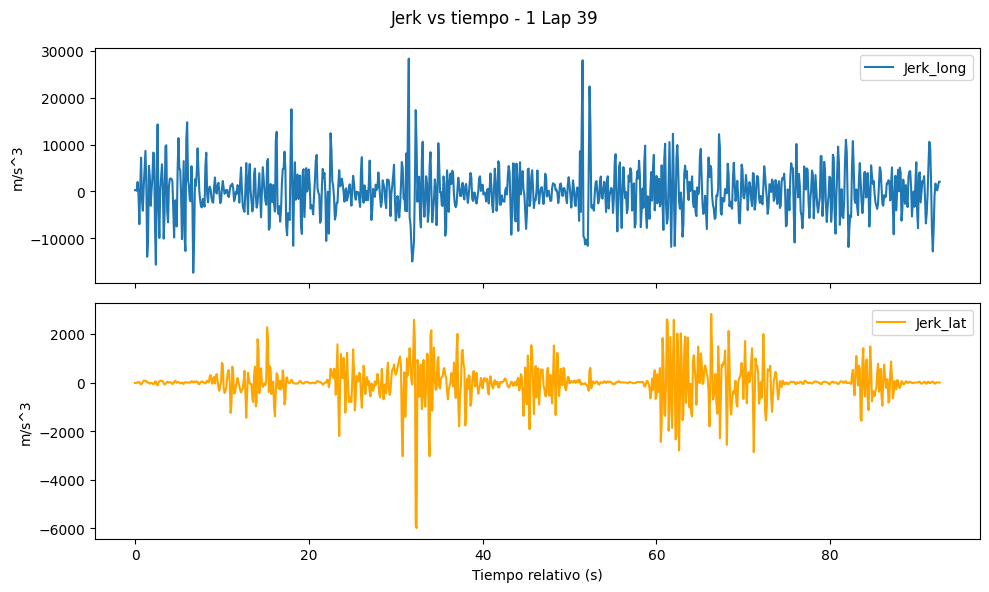

In [9]:
# Jerk longitudinal y lateral vs tiempo para el piloto más rápido
d = fastest['Driver']; lap = fastest['LapNumber']
sel_enr = enriched[(enriched.Driver == d) & (enriched.LapNumber == lap)]
fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
ax[0].plot(sel_enr['RelativeTime_s'], sel_enr['Jerk_long'], label='Jerk_long')
ax[0].set_ylabel('m/s^3')
ax[0].legend()
ax[1].plot(sel_enr['RelativeTime_s'], sel_enr['Jerk_lat'], label='Jerk_lat', color='orange')
ax[1].set_xlabel('Tiempo relativo (s)')
ax[1].set_ylabel('m/s^3')
ax[1].legend()
fig.suptitle(f'Jerk vs tiempo - {d} Lap {lap}')
plt.tight_layout()
plt.show()

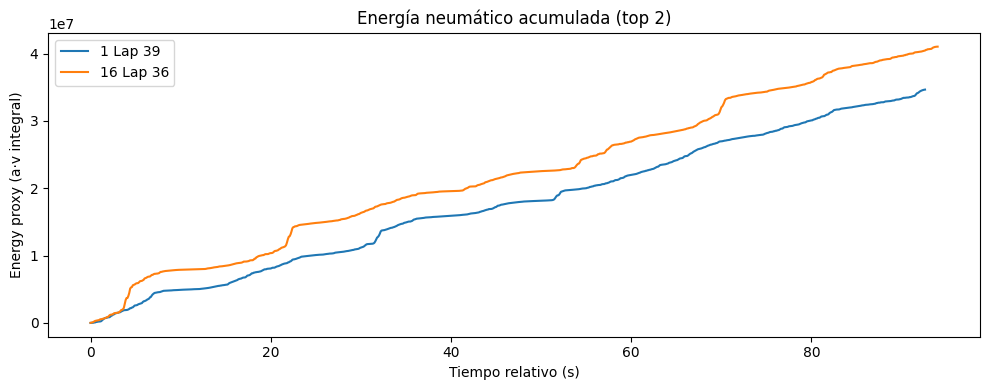

In [10]:
# Evolución del índice de energía de neumático para los dos más rápidos
fig, ax = plt.subplots(figsize=(10,4))
for _, row in top2.iterrows():
    d = row['Driver']; lap = row['LapNumber']
    sel_enr = enriched[(enriched.Driver == d) & (enriched.LapNumber == lap)]
    ax.plot(sel_enr['RelativeTime_s'], sel_enr['TireEnergyProxy'], label=f"{d} Lap {lap}")
ax.set_xlabel('Tiempo relativo (s)')
ax.set_ylabel('Energy proxy (a·v integral)')
ax.set_title('Energía neumático acumulada (top 2)')
ax.legend()
plt.tight_layout()
plt.show()

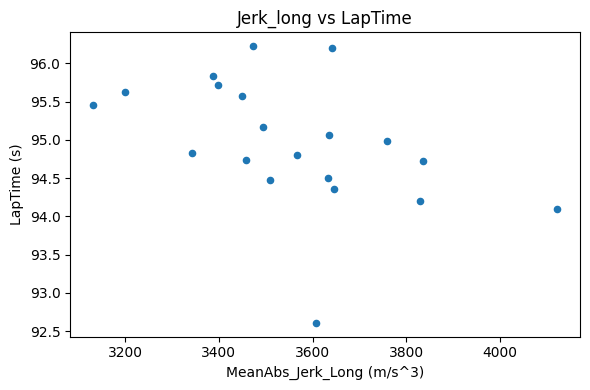

In [11]:
# Dispersión jerk vs lap time (suavidad vs performance)
ax = lap_feat.plot.scatter(x='MeanAbs_Jerk_Long', y='LapTimeSeconds', figsize=(6,4), title='Jerk_long vs LapTime')
ax.set_xlabel('MeanAbs_Jerk_Long (m/s^3)')
ax.set_ylabel('LapTime (s)')
plt.tight_layout()
plt.show()

## EDA estadístico (lap_features_module2)

In [12]:
import numpy as np
from pandas.plotting import scatter_matrix

# Estadísticos básicos
numeric_cols = ['LapTimeSeconds','MeanAbs_Jerk_Long','MeanAbs_Jerk_Lat','Energy_Index','Avg_Speed_mps','Brake_Aggression','Max_Lateral_g','Max_Longitudinal_g']
desc = lap_feat[numeric_cols].describe().T
desc

,count,mean,std,min,25%,50%,75%,max
LapTimeSeconds,20.0,9.495975e+01,8.405463e-01,9.260800e+01,9.449925e+01,9.490850e+01,9.558550e+01,9.622600e+01
MeanAbs_Jerk_Long,20.0,3.555643e+03,2.273618e+02,3.132103e+03,3.435646e+03,3.537292e+03,3.641963e+03,4.120783e+03
MeanAbs_Jerk_Lat,20.0,3.622446e+02,2.124177e+01,3.237062e+02,3.452780e+02,3.593856e+02,3.775465e+02,3.999999e+02
Energy_Index,20.0,3.412486e+07,2.606136e+06,3.020911e+07,3.229617e+07,3.458963e+07,3.531816e+07,4.102412e+07
Avg_Speed_mps,20.0,5.649524e+01,5.042597e-01,5.575996e+01,5.611563e+01,5.653812e+01,5.678472e+01,5.786635e+01
Brake_Aggression,20.0,4.046675e-01,8.866030e-03,3.907295e-01,3.990604e-01,4.037319e-01,4.101495e-01,4.192588e-01
Max_Lateral_g,20.0,8.946607e+01,2.452254e+01,6.770664e+01,7.230934e+01,8.037363e+01,9.590261e+01,1.511821e+02
Max_Longitudinal_g,20.0,4.488838e+02,1.689960e+02,2.185402e+02,2.806625e+02,4.667281e+02,5.703867e+02,7.093365e+02


In [13]:
# Correlación de variables con el LapTimeSeconds
corr = lap_feat[numeric_cols].corr()
display(corr)
corr['LapTimeSeconds'].sort_values()

,LapTimeSeconds,MeanAbs_Jerk_Long,MeanAbs_Jerk_Lat,Energy_Index,Avg_Speed_mps,Brake_Aggression,Max_Lateral_g,Max_Longitudinal_g
LapTimeSeconds,1.000000,-0.464545,-0.635616,-0.461462,-0.991438,0.375835,-0.221996,-0.266151
MeanAbs_Jerk_Long,-0.464545,1.000000,0.546161,0.928402,0.464275,-0.143368,0.302348,0.602519
MeanAbs_Jerk_Lat,-0.635616,0.546161,1.000000,0.465829,0.625773,-0.237049,0.556853,0.306818
Energy_Index,-0.461462,0.928402,0.465829,1.000000,0.464978,-0.041335,0.337380,0.789481
Avg_Speed_mps,-0.991438,0.464275,0.625773,0.464978,1.000000,-0.382452,0.241144,0.288610
Brake_Aggression,0.375835,-0.143368,-0.237049,-0.041335,-0.382452,1.000000,0.033297,-0.009509
Max_Lateral_g,-0.221996,0.302348,0.556853,0.337380,0.241144,0.033297,1.000000,0.230816
Max_Longitudinal_g,-0.266151,0.602519,0.306818,0.789481,0.288610,-0.009509,0.230816,1.000000


Avg_Speed_mps        -0.991438
MeanAbs_Jerk_Lat     -0.635616
MeanAbs_Jerk_Long    -0.464545
Energy_Index         -0.461462
Max_Longitudinal_g   -0.266151
Max_Lateral_g        -0.221996
Brake_Aggression      0.375835
LapTimeSeconds        1.000000
Name: LapTimeSeconds, dtype: float64

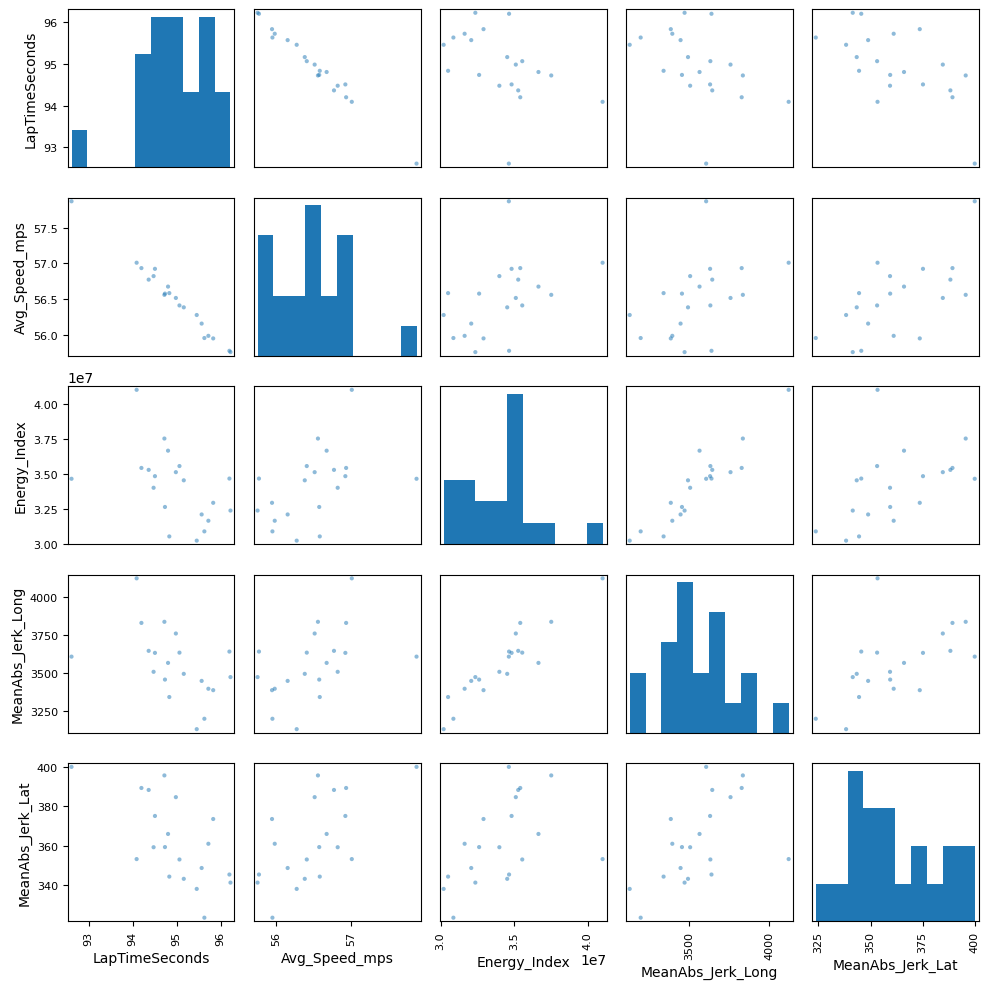

In [14]:
# Scatter matrix reducido para evitar demasiadas combinaciones
scatter_cols = ['LapTimeSeconds','Avg_Speed_mps','Energy_Index','MeanAbs_Jerk_Long','MeanAbs_Jerk_Lat']
axarr = scatter_matrix(lap_feat[scatter_cols], figsize=(10,10), diagonal='hist')
plt.tight_layout()
plt.show()

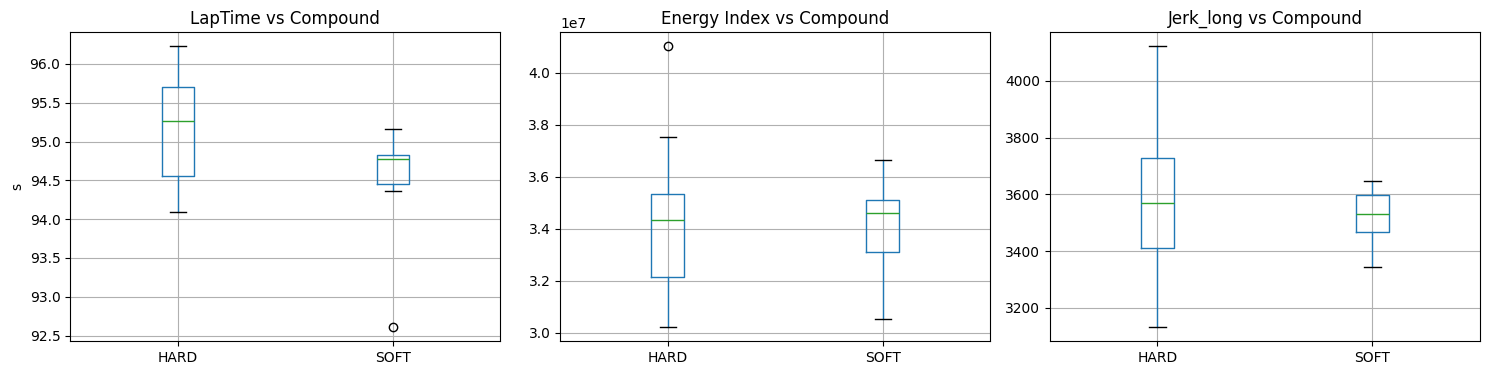

In [15]:
# Distribuciones por compuesto de neumático
fig, ax = plt.subplots(1,3, figsize=(15,4))
lap_feat.boxplot(column='LapTimeSeconds', by='Compound', ax=ax[0])
ax[0].set_title('LapTime vs Compound'); ax[0].set_ylabel('s'); ax[0].set_xlabel('')
lap_feat.boxplot(column='Energy_Index', by='Compound', ax=ax[1])
ax[1].set_title('Energy Index vs Compound'); ax[1].set_xlabel('')
lap_feat.boxplot(column='MeanAbs_Jerk_Long', by='Compound', ax=ax[2])
ax[2].set_title('Jerk_long vs Compound'); ax[2].set_xlabel('')
fig.suptitle(''); plt.tight_layout(); plt.show()

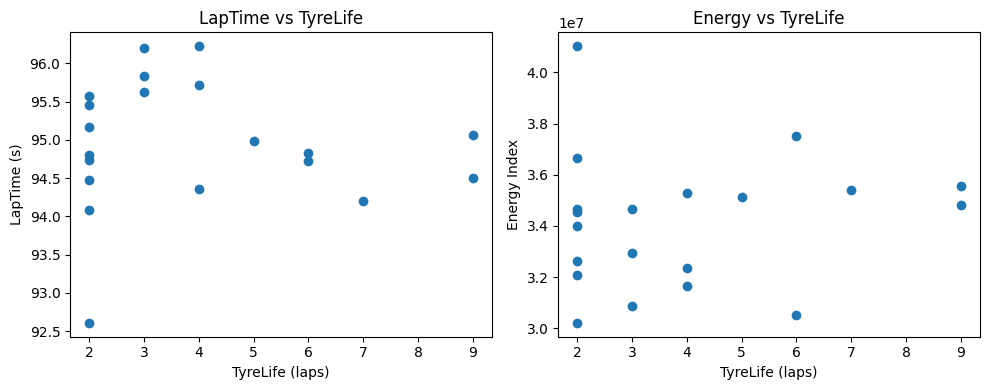

In [16]:
# Relación TyreLife con energía y tiempo de vuelta
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(lap_feat['TyreLife'], lap_feat['LapTimeSeconds'])
ax[0].set_xlabel('TyreLife (laps)'); ax[0].set_ylabel('LapTime (s)'); ax[0].set_title('LapTime vs TyreLife')
ax[1].scatter(lap_feat['TyreLife'], lap_feat['Energy_Index'])
ax[1].set_xlabel('TyreLife (laps)'); ax[1].set_ylabel('Energy Index'); ax[1].set_title('Energy vs TyreLife')
plt.tight_layout(); plt.show()

## Visuales adicionales (EDA enriquecido)

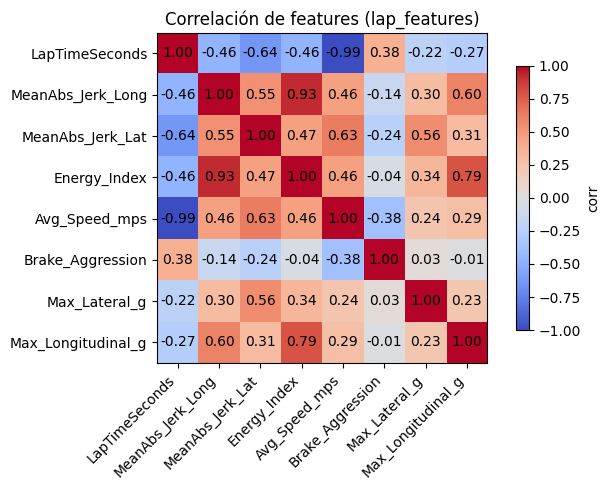

In [17]:
# Heatmap de correlación (lap_features)
import numpy as np
fig, ax = plt.subplots(figsize=(7,5))
corr = lap_feat[numeric_cols].corr()
im = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.iloc[i,j]:.2f}", ha='center', va='center', color='black')
fig.colorbar(im, ax=ax, shrink=0.8, label='corr')
ax.set_title('Correlación de features (lap_features)')
plt.tight_layout(); plt.show()

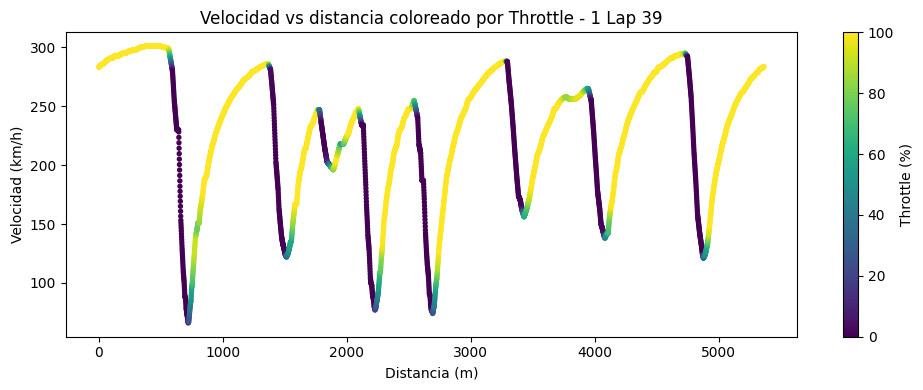

In [18]:
# Perfil de velocidad vs distancia con color por throttle (vuelta más rápida)
sel_dist = telemetry_dist[(telemetry_dist.Driver == fastest['Driver']) & (telemetry_dist.LapNumber == fastest['LapNumber'])]
fig, ax = plt.subplots(figsize=(10,4))
sc = ax.scatter(sel_dist['Distance_m'], sel_dist['Speed'], c=sel_dist['Throttle'], cmap='viridis', s=8)
ax.set_xlabel('Distancia (m)'); ax.set_ylabel('Velocidad (km/h)');
ax.set_title(f'Velocidad vs distancia coloreado por Throttle - {fastest["Driver"]} Lap {fastest["LapNumber"]}')
cbar = plt.colorbar(sc, ax=ax); cbar.set_label('Throttle (%)')
plt.tight_layout(); plt.show()

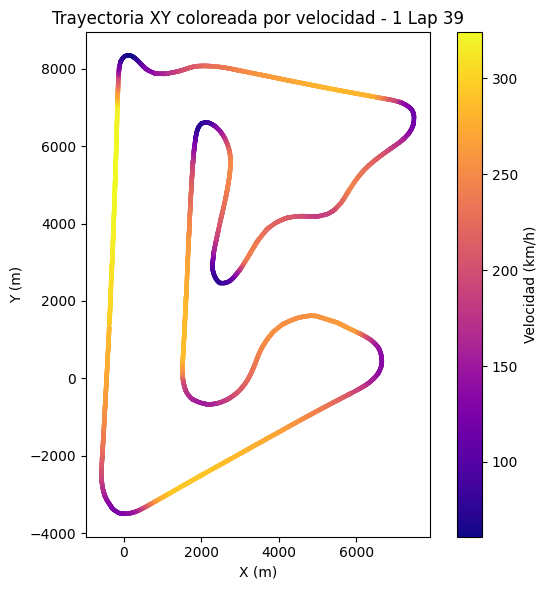

In [19]:
# Mapa XY coloreado por velocidad (vuelta más rápida)
fig, ax = plt.subplots(figsize=(6,6))
sc = ax.scatter(sel['X'], sel['Y'], c=sel['Speed'], cmap='plasma', s=5)
ax.set_aspect('equal', 'box')
ax.set_title(f'Trayectoria XY coloreada por velocidad - {fastest["Driver"]} Lap {fastest["LapNumber"]}')
ax.set_xlabel('X (m)'); ax.set_ylabel('Y (m)')
cbar = plt.colorbar(sc, ax=ax); cbar.set_label('Velocidad (km/h)')
plt.tight_layout(); plt.show()

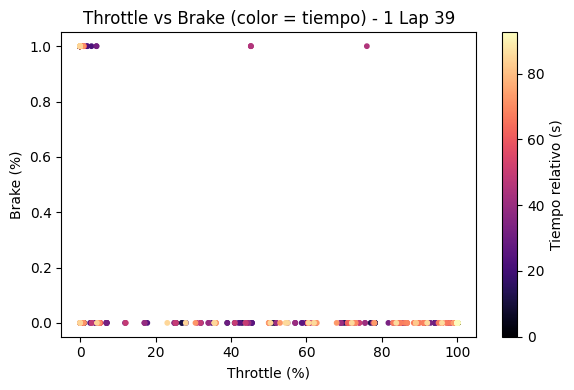

In [20]:
# Throttle vs Brake coloreado por tiempo (vuelta más rápida)
fig, ax = plt.subplots(figsize=(6,4))
sc = ax.scatter(sel_pedal['Throttle'], sel_pedal['Brake'], c=sel_pedal['RelativeTime_s'], cmap='magma', s=10)
ax.set_xlabel('Throttle (%)'); ax.set_ylabel('Brake (%)')
ax.set_title(f'Throttle vs Brake (color = tiempo) - {fastest["Driver"]} Lap {fastest["LapNumber"]}')
cbar = plt.colorbar(sc, ax=ax); cbar.set_label('Tiempo relativo (s)')
plt.tight_layout(); plt.show()

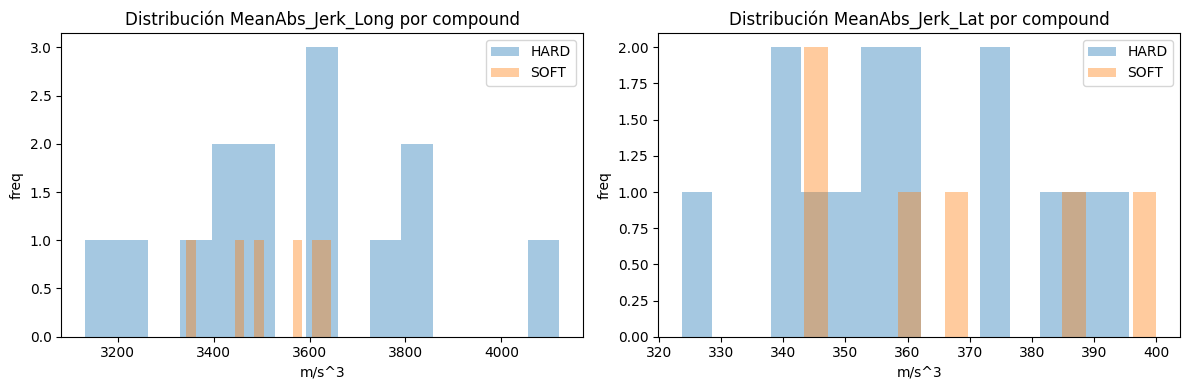

In [21]:
# Distribución de jerk por compuesto
fig, ax = plt.subplots(1,2, figsize=(12,4))
for comp, data in lap_feat.groupby('Compound'):
    ax[0].hist(data['MeanAbs_Jerk_Long'].dropna(), bins=15, alpha=0.4, label=comp)
    ax[1].hist(data['MeanAbs_Jerk_Lat'].dropna(), bins=15, alpha=0.4, label=comp)
ax[0].set_title('Distribución MeanAbs_Jerk_Long por compound'); ax[0].set_xlabel('m/s^3'); ax[0].set_ylabel('freq')
ax[1].set_title('Distribución MeanAbs_Jerk_Lat por compound'); ax[1].set_xlabel('m/s^3'); ax[1].set_ylabel('freq')
ax[0].legend(); ax[1].legend()
plt.tight_layout(); plt.show()

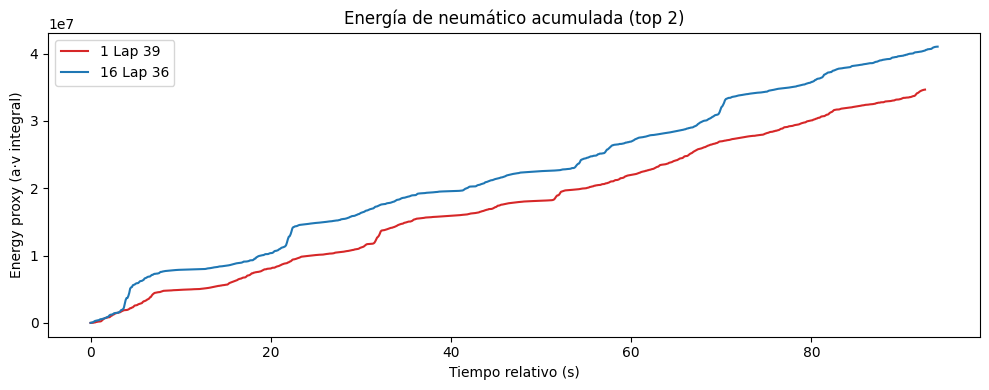

In [22]:
# Energy proxy a lo largo del tiempo para top 2 (color por piloto)
fig, ax = plt.subplots(figsize=(10,4))
colors = ['tab:red','tab:blue']
for (idx, row), color in zip(top2.iterrows(), colors):
    d = row['Driver']; lap = row['LapNumber']
    sel_enr = enriched[(enriched.Driver == d) & (enriched.LapNumber == lap)]
    ax.plot(sel_enr['RelativeTime_s'], sel_enr['TireEnergyProxy'], color=color, label=f"{d} Lap {lap}")
ax.set_xlabel('Tiempo relativo (s)'); ax.set_ylabel('Energy proxy (a·v integral)')
ax.set_title('Energía de neumático acumulada (top 2)')
ax.legend(); plt.tight_layout(); plt.show()